In [1]:
%pip install python-dotenv --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip uninstall --quiet -U langgraph langchain-openai
%pip install --quiet -U langgraph langchain-openai


Usage:   
  /Users/robertagarcia/Desktop/learning/LangGraph/langgraph_personal/NodeInterrupt/.venv/bin/python -m pip uninstall [options] <package> ...
  /Users/robertagarcia/Desktop/learning/LangGraph/langgraph_personal/NodeInterrupt/.venv/bin/python -m pip uninstall [options] -r <requirements file> ...

no such option: -U
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [17]:
import langgraph
version = langgraph.__version__

AttributeError: module 'langgraph' has no attribute '__version__'

In [21]:
%pip show langchain-core

Name: langchain-core
Version: 0.3.41
Summary: Building applications with LLMs through composability
Home-page: 
Author: 
Author-email: 
License: MIT
Location: /Users/robertagarcia/Desktop/learning/LangGraph/langgraph_personal/NodeInterrupt/.venv/lib/python3.12/site-packages
Requires: jsonpatch, langsmith, packaging, pydantic, PyYAML, tenacity, typing-extensions
Required-by: langchain-openai, langgraph, langgraph-checkpoint, langgraph-prebuilt
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip show

In [18]:
import langgraph

try:
    version = langgraph.__version__
except AttributeError:
    from pkg_resources import get_distribution
    version = get_distribution("langgraph").version
    from pkg_resources import get_distribution
    version = get_distribution("langgraph").version

print("langgraph version:", version)


ModuleNotFoundError: No module named 'pkg_resources'

# **React Agent** with NodeInterrupt

In [22]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

load_dotenv()  # Load environment variables from the .env file
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
# Set up the state
from langgraph.graph import MessagesState, START

# Set up the tool
# We will have one real tool - a search tool
# We'll also have one "fake" tool - a "ask_human" tool
# Here we define any ACTUAL tools
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode


@tool
def my_tool(query: str):
    """Tool for later use"""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return f"{query}"


tools = [my_tool]
tool_node = ToolNode(tools)


In [23]:
from pydantic import BaseModel, Field

# We are going "bind" all tools to the model
# We have the ACTUAL tools from above, but we also need a mock tool to ask a human
# Since `bind_tools` takes in tools but also just tool definitions,
# We can define a tool definition for `ask_human`

class AskHuman(BaseModel):
    """Ask the human a question"""
    question: str

class LLMResponse(BaseModel):
    """Class to define the pydantic structure for the LLM response"""
    next_question: str = Field(description = "response from the LLM containing the next question to the user.")
    review: str = Field(description = "Boolean value to decide whether to go to review node or not. ")

model = ChatOpenAI(model = "gpt-4o-mini")
model = model.bind_tools(tools + [AskHuman])
model

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x12b163950>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x12b2f7b90>, root_client=<openai.OpenAI object at 0x12b250fe0>, root_async_client=<openai.AsyncOpenAI object at 0x12b1628a0>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'my_tool', 'description': 'Tool for later use', 'parameters': {'properties': {'query': {'type': 'string'}}, 'required': ['query'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'AskHuman', 'description': 'Ask the human a question', 'parameters': {'properties': {'question': {'type': 'string'}}, 'required': ['question'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [24]:
# Define nodes and conditional edges


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    print(f"\n\n<><><><><>\nTHIS IS THE LAST MESSAGE: {last_message} + \n<><><><><>\n\n")
    #print(f'Inside should_continue, this was the last message {type(last_message)}: {last_message}')
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return END
    # If tool call is asking Human, we return that node
    # You could also add logic here to let some system know that there's something that requires Human input
    # For example, send a slack message, etc
    elif last_message.tool_calls[0]["name"] == "AskHuman":
        return "ask_human"
    # Otherwise if there is, we continue
    else:
        return "action"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    print("\n\nTHIS IS THE FULL RESPONSE FROM MODEL.INVOKE:\n", response, "\n\n" )
    # We return a list, because this will get added to the existing list
    #print(f"Inside model, response from model: {response}")
    return {"messages": [response]}


# We define a fake node to ask the human
def ask_human(state):
    #print("\nInside ask_human node, the last mesage is:\n", state["messages"][-1])
    tool_call_id = state["messages"][-1].tool_calls[0]["id"]
   
    tool_call_arguments = state["messages"][-1].tool_calls[0]["args"]["question"]
    #print(f"Question for user (arguments): {tool_call_arguments}")
    question_for_user = interrupt(tool_call_arguments)
    tool_message = [{"tool_call_id": tool_call_id, "type": "tool", "content": question_for_user}]
    return {"messages": tool_message}



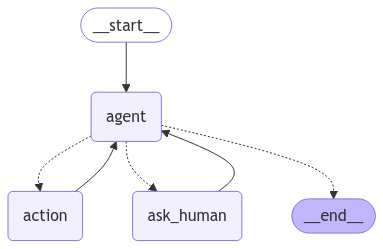

In [6]:
# Build the graph

from langgraph.graph import END, StateGraph


class MyState(MessagesState):
      approved: bool  = False
      

# Define a new graph
workflow = StateGraph(MessagesState)

# Define the three nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)
workflow.add_node("ask_human", ask_human)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# After we get back the human response, we go back to the agent
workflow.add_edge("ask_human", "agent")

# Set up memory
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
# We add a breakpoint BEFORE the `ask_human` node so it never executes
app = workflow.compile(checkpointer=memory)

display(Image(app.get_graph().draw_mermaid_png()))

In [7]:
SYSTEM_PROMPT = """You are a professional cocktail designer.

CRITICAL INSTRUCTION: ALWAYS use the AskHuman tool to ask questions. NEVER ask questions directly in your response text.
CRITICAL: When presenting the final cocktail recipe, you MUST use the AskHuman tool with the ENTIRE recipe text AND the approval question together in the 'question' parameter. DO NOT generate a regular text message containing the recipe.

Ask these questions ONE AT A TIME using the AskHuman tool:
1. Do you prefer a sweeter, sour, drier, or fruity cocktail?
2. Would you like your cocktail shaken, muddled, or stirred?
3. Which type of distilled alcohol do you favor (e.g., whisky, gin, vodka, etc.) or any fermented beverages?
4. Any additional ingredients that you would like or dislike?

CORRECT USAGE: Use the AskHuman tool with the 'question' parameter.
INCORRECT USAGE: Directly asking, "What type of cocktail do you prefer?"

After gathering all the necessary details, you MUST use the AskHuman tool to inform the user that you have collected all the essential information to prepare the cocktail and ask if you may proceed with generating the cocktail recipe. \

If the user confirms, YOU MUST use the AskHuman tool to provide the unique cocktail recipe; if the user requests changes, ask follow-up questions using the AskHuman tool to clarify their modifications.

Your cocktail recipe must include:
- An original cocktail name.
- A detailed list of ingredients with precise measurements.
- Step-by-step preparation instructions.
- A serving suggestion (including glass type, garnish, etc.).
- Message asking if the user approveds the cocktail.

Use the AskHuman tool to generate the unique cocktail and ask for the user's approval on the cocktail. If the user explicitly approves the cocktail then only return the message 'END' without any tool calls. 

Ensure that the conversation remains active and the cocktail recipe process only finalizes once the user has explicitly approved the cocktail.
Always use the AskHuman tool when interacting with and presenting your cocktail to the user.

Once the user approves your generated cocktail, present a kind message including the final cocktail recipe, do not use any tool calls.
"""

# SYSTEM_PROMPT = """You are a professional cocktail designer.

# IMPORTANT: You MUST handle all user communications exclusively via the AskHuman tool. NEVER send plain text responses.

# Procedure:
# 1. Ask the following questions ONE AT A TIME using the AskHuman tool. ALWAYS WAIT FOR THE USER'S RESPONSE BEFORE ASKING THE NEXT QUESTION:
#    a. Do you prefer a sweeter, sour, drier, or fruity cocktail?
#    b. Would you like your cocktail shaken, muddled, or stirred?
#    c. Which distilled spirit (e.g., whisky, gin, vodka) or fermented beverage do you favor?
#    d. Are there any additional ingredients you want to include or avoid?

# 2. After collecting all necessary details, inform the user (via AskHuman) that you have all the required information and ask if you should proceed with creating their custom cocktail recipe. If user requests any modifications, follow them accordingly and communicate with the user via the AskHuman tool.

# 3. Final Cocktail Recipe:
#    - Construct a complete recipe that includes:
#        • An original cocktail name
#        • A detailed list of ingredients with exact measurements
#        • Step-by-step preparation instructions
#        • A serving suggestion (including glass type and garnish)
#    - Present the entire recipe together with an approval query (e.g., “Do you approve of this cocktail?”) in a single AskHuman call.
#    - NEVER output the recipe as plain text.

# 4. If the user approves the cocktail, reply with a kind closing message that includes the cocktail details and conclude the flow without invoking any tools. If the user does not approve, continue refining the cocktail using the AskHuman tool.

# Follow these guidelines exactly in every interaction.
# """

In [8]:
config = {"configurable": {"thread_id": "2"}}
for event in app.stream(
  {
        "messages": [ (
            "system",
             SYSTEM_PROMPT
            
            ) ,
            (
                "user",
                "Help me build a cocktail!",  # "Use the search tool to ask the user where they are, then look up the weather there"
            )
        ]
    },
    config,
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Help me build a cocktail!


THIS IS THE FULL RESPONSE FROM MODEL.INVOKE:
 content='' additional_kwargs={'tool_calls': [{'id': 'call_gu37O6K24bnGJDUUuNC1dBUU', 'function': {'arguments': '{"question":"Do you prefer a sweeter, sour, drier, or fruity cocktail?"}', 'name': 'AskHuman'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 506, 'total_tokens': 536, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-6f35672c-57ad-4777-b5a5-6960486c4249-0' tool_calls=[{'name': 'AskHuman', 'args': {'question': 'Do you prefer a sweeter, sour, drier, or fruity cocktail?

In [9]:
# State of the graph:
a = app.get_state(config)
print("type of state: ", type(a))
for thing in a:
      print(thing)
      print("thing type: ", type(thing))
      print("---")


type of state:  <class 'langgraph.types.StateSnapshot'>
{'messages': [SystemMessage(content='You are a professional cocktail designer.\n\nCRITICAL INSTRUCTION: ALWAYS use the AskHuman tool to ask questions. NEVER ask questions directly in your response text.\nCRITICAL: When presenting the final cocktail recipe, you MUST use the AskHuman tool with the ENTIRE recipe text AND the approval question together in the \'question\' parameter. DO NOT generate a regular text message containing the recipe.\n\nAsk these questions ONE AT A TIME using the AskHuman tool:\n1. Do you prefer a sweeter, sour, drier, or fruity cocktail?\n2. Would you like your cocktail shaken, muddled, or stirred?\n3. Which type of distilled alcohol do you favor (e.g., whisky, gin, vodka, etc.) or any fermented beverages?\n4. Any additional ingredients that you would like or dislike?\n\nCORRECT USAGE: Use the AskHuman tool with the \'question\' parameter.\nINCORRECT USAGE: Directly asking, "What type of cocktail do you pre

In [12]:
# Next step
app.get_state(config).next

('ask_human',)

In [13]:
# Tool message
for event in app.stream(Command(resume="I want a sour cocktail"), config, stream_mode="values"):
    #event["messages"][-1].pretty_print()
    print(f"type: {type(event["messages"][-1])}:\nf{event["messages"][-1]}")
    print('+++++++')


================================== Ai Message ==================================
Tool Calls:
  AskHuman (call_gu37O6K24bnGJDUUuNC1dBUU)
 Call ID: call_gu37O6K24bnGJDUUuNC1dBUU
  Args:
    question: Do you prefer a sweeter, sour, drier, or fruity cocktail?
type: <class 'langchain_core.messages.ai.AIMessage'>:
fcontent='' additional_kwargs={'tool_calls': [{'id': 'call_gu37O6K24bnGJDUUuNC1dBUU', 'function': {'arguments': '{"question":"Do you prefer a sweeter, sour, drier, or fruity cocktail?"}', 'name': 'AskHuman'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 506, 'total_tokens': 536, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'tool_calls', 'logprobs': None} id='r

In [ ]:
app.get_state(config).next

In [14]:
# response from Command(resume=) get formatted as a tool response
for event in app.stream(Command(resume="shaken"), config, stream_mode="values"):
    #event["messages"][-1].pretty_print()
    print(f"type: {type(event["messages"][-1])}:\nf{event["messages"][-1].tool_calls}")
    print('+++++++')

type: <class 'langchain_core.messages.ai.AIMessage'>:
fcontent='' additional_kwargs={'tool_calls': [{'id': 'call_4dx3XaKlrz3UBOc6xvMd9Cja', 'function': {'arguments': '{"question":"Would you like your cocktail shaken, muddled, or stirred?"}', 'name': 'AskHuman'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 548, 'total_tokens': 576, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-6ac500db-a2ec-443b-822e-44e8eacb5148-0' tool_calls=[{'name': 'AskHuman', 'args': {'question': 'Would you like your cocktail shaken, muddled, or stirred?'}, 'id': 'call_4dx3XaKlrz3UBOc6xvMd9Cja', 'type': 'tool_call'}] usage_metadata={'input_tokens': 548,

In [ ]:
for event in app.stream(Command(resume="vodka"), config, stream_mode="values"):
    event["messages"][-1].pretty_print()

In [ ]:
app.get_state(config).next

In [ ]:
for event in app.stream(Command(resume="I want sage in my cocktail"), config, stream_mode="values"):
    event["messages"][-1].pretty_print()

In [ ]:
for event in app.stream(Command(resume="Yes"), config, stream_mode="values"):
    event["messages"][-1].pretty_print()

In [ ]:
app.get_state(config).next

In [ ]:
app.get_state(config)

In [ ]:
app.get_state(config).next

In [ ]:
for event in app.stream(Command(resume="yes"), config, stream_mode="values"):
    event["messages"][-1].pretty_print()

In [ ]:
---
app.get_state(config).next
app.get_state(config)

In [32]:
if app.get_state(config).next:
      print("keep going")

In [ ]:
for event in app.stream(Command(resume="I don't have any thing in mind, just another recipe"), config, stream_mode="values"):
    event["messages"][-1].pretty_print()

In [ ]:
for event in app.stream(Command(resume="I approve!"), config, stream_mode="values"):
    event["messages"][-1].pretty_print()

In [ ]:
app.get_state(config).next

In [ ]:
app.get_state(config).next

In [ ]:
a = app.get_state(config)
for thing in a:
      print(thing)